In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt


In [31]:

from datetime import datetime

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
tf.random.Generator = None
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization

In [2]:
images = [cv2.imread(file) for file in glob.glob('Downloads/ISIC2018_Task1-2_Training_Input_x2/*.jpg')]
masks = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob('Downloads/ISIC2018_Task1_Training_GroundTruth_x2/*.png')]

In [3]:
width = 256
height = 256
channels = 3

In [4]:
for i in range(len(images)):
    images[i] = cv2.resize(images[i],(height,width))
    images[i] = images[i]/255

In [5]:
for i in range(len(masks)):
    masks[i] = cv2.resize(masks[i],(height,width))
    masks[i] = masks[i]/255
    masks[i][masks[i] > 0.5] = 1
    masks[i][masks[i] <= 0.5] = 0
    

In [6]:
X = np.zeros([2594, height, width, channels])
y = np.zeros([2594, height, width])

In [7]:
for i in range(len(images)):
    X[i] = images[i]

In [8]:
for i in range(len(masks)):
    y[i] = masks[i]
        
y = y[:, :, :, np.newaxis]

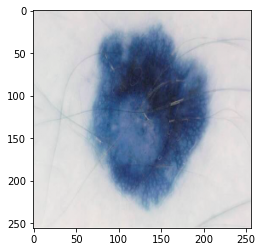

In [9]:
plt.imshow(X[2])

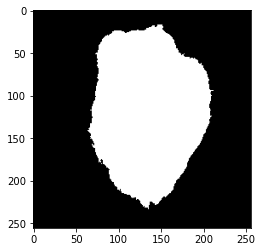

In [10]:
plt.imshow(y[2], cmap='gray')

In [11]:
# Split train:validation:test = 6:2:2 ------->  1556:519:519
X_train = X[0:1556,:,:,:]
X_val = X[1556:1556+519,:,:,:]
X_test = X[1556+519:2594,:,:,:]

y_train = y[0:1556,:,:,:]
y_val = y[1556:1556+519,:,:,:]
y_test = y[1556+519:2594,:,:,:]

In [28]:
y_val.shape

(519, 256, 256, 1)

In [15]:
X_train.dtype

dtype('float64')

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
tf.random.Generator = None
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization

C:\Users\s4511528\.conda\envs\tf2_ljm\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.1.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [18]:
def context_module(input, filter):

    out = InstanceNormalization()(input)
    out = LeakyReLU(alpha=0.01)(out)
    out = Conv2D(filter,(3,3),padding='same')(out)
    out = Dropout(0.3)(out)
    out = InstanceNormalization()(out)
    out = LeakyReLU(alpha=0.01)(out)
    out = Conv2D(filter,(3,3),padding='same')(out)
    
    return out
    

In [19]:
def upsampling_module(input, filter):
    out = UpSampling2D()(input)
    out = Conv2D(filter,(3,3),padding='same')(out)
    
    return out

In [20]:
def localization_module(input, filter):
    out = Conv2D(filter,(3,3),padding='same')(input)
    out = Conv2D(filter,(1,1),padding='same')(out)
    
    return out

In [41]:
inputs = Input(shape = (height, width, channels))

c1 = Conv2D(16, (3, 3),padding='same') (inputs)
cm1 = context_module(c1, 16)
a1 = add([c1,cm1])
c2 = Conv2D(32, (3, 3), strides = 2, padding='same')(a1)
cm2 = context_module(c2, 32)
a2 = add([c2,cm2])
c3 = Conv2D(64, (3, 3), strides = 2, padding='same')(a2)
cm3 = context_module(c3, 64)
a3 = add([c3,cm3])
c4 = Conv2D(128, (3, 3), strides = 2, padding='same')(a3)
cm4 = context_module(c4, 128)
a4 = add([c4,cm4])
c5 = Conv2D(256, (3, 3), strides = 2, padding='same')(a4)
cm5 = context_module(c5, 256)
a5 = add([c5,cm5])   


u1 = upsampling_module(a5, 128)
con1 = concatenate([u1, a4])

l1 = localization_module(con1, 128)
u2 = upsampling_module(l1, 64)
con2 = concatenate([u2, a3])
l2 = localization_module(con2, 64)
u3 = upsampling_module(l2, 32)
con3 = concatenate([u3, a2])

l3 = localization_module(con3, 32)
u4 = upsampling_module(l3, 16)
con4 = concatenate([u4, a1])

c6 = Conv2D(32, (3, 3),padding='same') (con4)


s1 = Conv2D(1, (1,1), padding='same')(l2)
up1 = UpSampling2D()(s1)
s2 = Conv2D(1, (1,1), padding='same')(l3)
a6 = add([up1,s2])
up2 = UpSampling2D()(a6)
s3 = Conv2D(1, (1,1), padding='same')(c6)
a7 = add([up2,s3])

outputs = Conv2D(1, (1, 1), activation = 'sigmoid') (a7)

model = Model(inputs=[inputs], outputs=[outputs])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
instance_normalization_20 (Inst (None, 256, 256, 16) 32          conv2d_60[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_20 (LeakyReLU)      (None, 256, 256, 16) 0           instance_normalization_20[0][0]  
____________________________________________________________________________________________

In [42]:
def dice_coef(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    y_pred = tf.cast(tf.math.greater(y_pred, 0.5),tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [43]:
#logs_dir = "logs/Unet_"+datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [TensorBoard(),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4,min_lr=0.0000001),
             ModelCheckpoint('Unet.h5',monitor='val_loss',verbose=1,save_best_only=True)]
metric = ['acc', dice_coef, Recall(), Precision()]

In [44]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metric)

In [47]:
history = model.fit(x = X_train, y = y_train, validation_data=(X_val, y_val), batch_size=16, epochs=30)

Train on 1556 samples, validate on 519 samples
Epoch 1/30
1556/1556 [==============================] - 17s 11ms/sample - loss: 0.1252 - acc: 0.9498 - dice_coef: 0.8829 - recall_2: 0.8600 - precision_2: 0.9125 - val_loss: 0.1425 - val_acc: 0.9450 - val_dice_coef: 0.7739 - val_recall_2: 0.8185 - val_precision_2: 0.7430
Epoch 2/30
1556/1556 [==============================] - 17s 11ms/sample - loss: 0.1181 - acc: 0.9528 - dice_coef: 0.8927 - recall_2: 0.8717 - precision_2: 0.9152 - val_loss: 0.2248 - val_acc: 0.9195 - val_dice_coef: 0.7148 - val_recall_2: 0.8835 - val_precision_2: 0.6105
Epoch 3/30
1556/1556 [==============================] - 17s 11ms/sample - loss: 0.1279 - acc: 0.9488 - dice_coef: 0.8807 - recall_2: 0.8598 - precision_2: 0.9084 - val_loss: 0.2836 - val_acc: 0.8917 - val_dice_coef: 0.6561 - val_recall_2: 0.9107 - val_precision_2: 0.5245
Epoch 4/30
1556/1556 [==============================] - 17s 11ms/sample - loss: 0.1273 - acc: 0.9494 - dice_coef: 0.8839 - recall_2: 0.86

In [50]:
results = model.evaluate(X_test, y_test, batch_size = 16)

519/519 [==============================] - 2s 3ms/sample - loss: 0.2566 - acc: 0.9057 - dice_coef: 0.8399 - recall_2: 0.9371 - precision_2: 0.7696


In [51]:
predictions = model.predict(X_test)

In [61]:
for i in range(len(predictions)):
    predictions[i][predictions[i] > 0.5] = 1
    predictions[i][predictions[i] <= 0.5] = 0

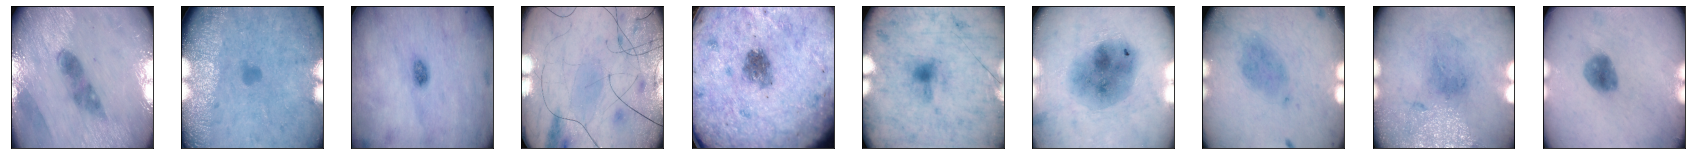

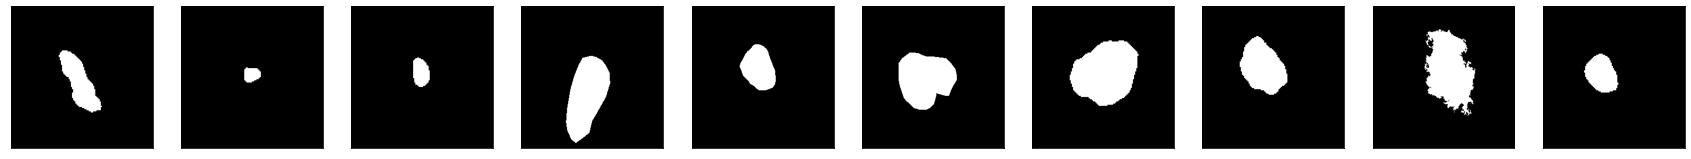

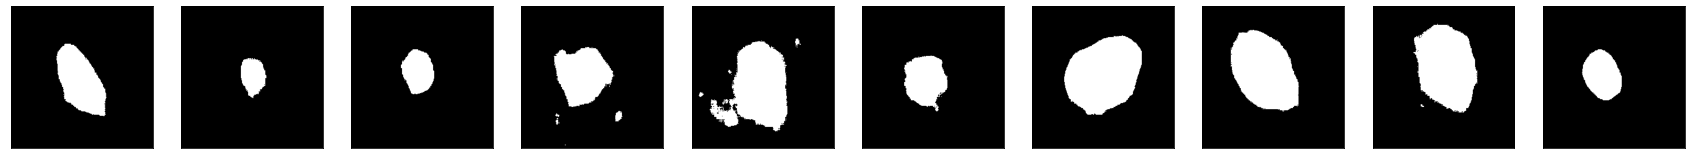

In [62]:
# Plot Origional/ Segmentation/ Prediction pictures

n = 10 
plt.figure(figsize=(30, 10))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.figure(figsize=(30, 10))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(y_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.figure(figsize=(30, 10))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(predictions[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [63]:
test_dice = dice_coef(y_test, predictions)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [68]:
print('Test Dice Coefficient: ', test_dice.numpy())

Test Dice Coefficient:  0.8451062
